<a href="https://colab.research.google.com/github/Vaishnav469/UpCycle/blob/main/UpCycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/Vaishnav469/UpCycle.git

Cloning into 'UpCycle'...
remote: Enumerating objects: 11126, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11126 (delta 1), reused 8 (delta 1), pack-reused 11114 (from 1)
Receiving objects: 100% (11126/11126), 913.90 MiB | 22.51 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Updating files: 100% (12549/12549), done.


In [ ]:
%cd .

/content


In [ ]:
!find ./UpCycle/upcycle_dataset -name ".ipynb_checkpoints" -delete

In [ ]:
import os
import random
from PIL import Image
import numpy as np
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split


In [ ]:
# Paths to your dataset
data_dir = './UpCycle/upcycle_dataset'

# Parameters
img_size = 224  # You can adjust this based on your model requirements
batch_size = 128
valid_split = 0.2  # 20% of the data for validation
test_split = 0.1

In [ ]:
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


In [ ]:
# Load dataset
dataset = datasets.ImageFolder(data_dir, transform=transform['train'])

# Calculate split sizes
test_size = int(test_split * len(dataset))
valid_size = int(valid_split * (len(dataset) - test_size))
train_size = len(dataset) - test_size - valid_size

# Split dataset
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

# Apply validation and test transforms
valid_dataset.dataset.transform = transform['valid']
test_dataset.dataset.transform = transform['test']

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


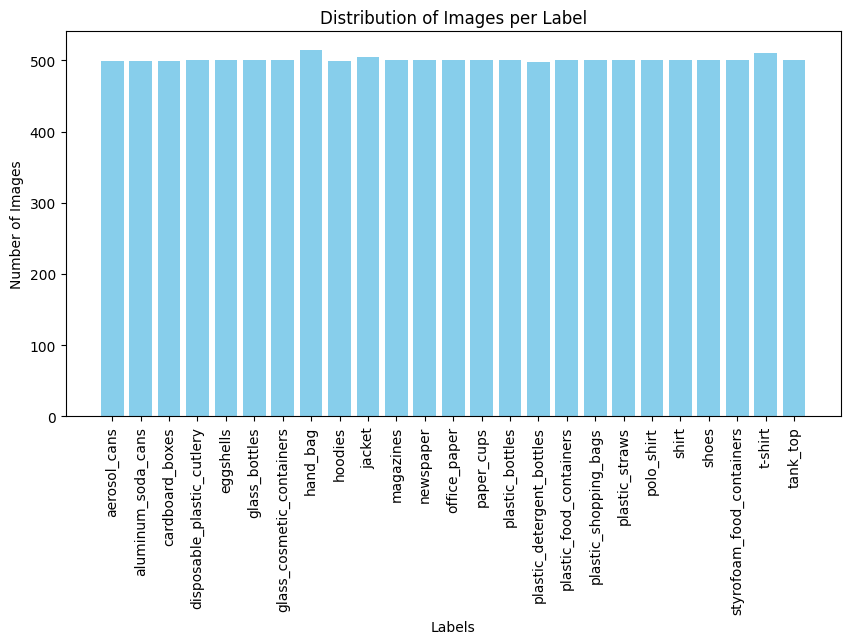

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Assuming 'dataset' is your ImageFolder dataset
labels = [label for _, label in dataset]
label_counts = Counter(labels)

# Get label names from dataset class indices
label_names = [dataset.classes[idx] for idx in label_counts.keys()]

plt.figure(figsize=(10, 5))
plt.bar(label_names, label_counts.values(), color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Label')
plt.xticks(rotation=90)  # Rotate label names for better readability
plt.show()


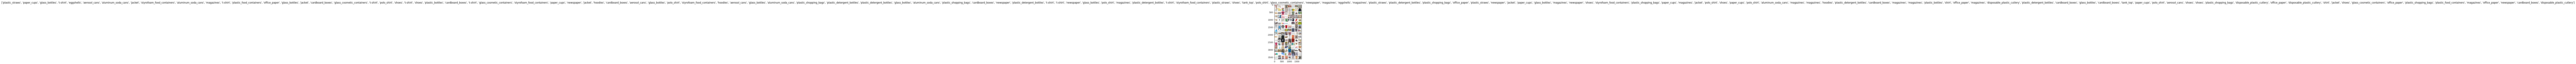

Sample data from Training Set


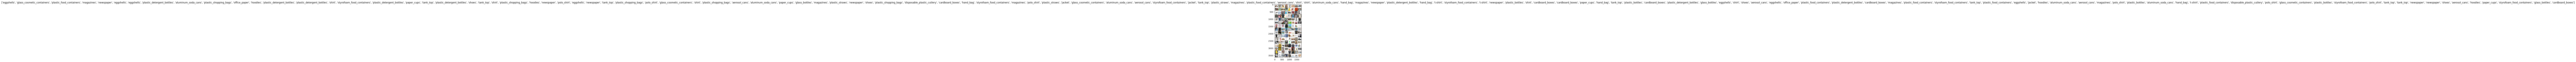

Sample data from Validation Set


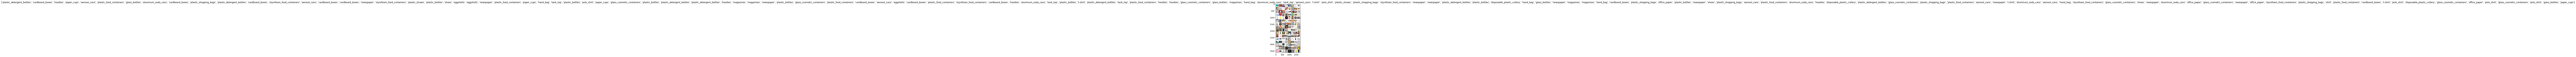

Sample data from Test Set


In [ ]:
import matplotlib.pyplot as plt
import torchvision

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def print_sample_data(loader, dataset_name):
    inputs, labels = next(iter(loader))
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[dataset.classes[x] for x in labels])
    print(f'Sample data from {dataset_name}')

print_sample_data(train_loader, "Training Set")
print_sample_data(valid_loader, "Validation Set")
print_sample_data(test_loader, "Test Set")



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class CustomCNNModel(nn.Module):
    def __init__(self, num_classes=25):
        super(CustomCNNModel, self).__init__()
        self.model = models.resnet50(pretrained=True)

        # Freeze all layers except the final fully connected layer
        for param in self.model.parameters():
            param.requires_grad = False

        layers_to_unfreeze = 10
        # Number of layers to unfreeze

        for param in list(self.model.parameters())[-layers_to_unfreeze:]:
          param.requires_grad = True

        num_features = self.model.fc.in_features
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5), # Dropout layer with 50% probability
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        return self.model(x)

def save_checkpoint(state, filename="checkpoint.pth.tar"):
    print(f"Saving checkpoint to {filename}")
    torch.save(state, filename)

def load_checkpoint(filename="checkpoint.pth.tar"):
    print(f"Loading checkpoint from {filename}")
    return torch.load(filename)

# Instantiate the model, criterion, and optimizer
num_classes = 25  # Adjust to your number of classes
model = CustomCNNModel(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.model.fc.parameters(), lr=0.0001) #trained till 20 epochs at 0.01, then switched to 0.001 and trained till 60.

def train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs, start_epoch=0):
    for epoch in range(start_epoch, num_epochs):
        print(f'Starting epoch {epoch+1}/{num_epochs}')
        model.train()
        running_loss = 0.0
        corrects_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            corrects_train += torch.sum(preds == labels.data)

        train_accuracy = corrects_train.double() / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        corrects_valid = 0

        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                preds = torch.argmax(outputs, dim=1)
                corrects_valid += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        val_loss = val_loss / len(valid_loader.dataset)
        val_accuracy = corrects_valid.double() / len(valid_loader.dataset)

        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}', flush=True)

        # Save checkpoint
        checkpoint = {
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }
        save_checkpoint(checkpoint)

# Load checkpoint if available
checkpoint_path = "checkpoint.pth.tar"
start_epoch = 0
if os.path.isfile(checkpoint_path):
    checkpoint = load_checkpoint(checkpoint_path)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_epoch = checkpoint['epoch']

# Assuming 'train_loader' and 'valid_loader' are already defined
# Adjust the batch size if needed
batch_size = 128

# Train and validate the model
num_epochs = 60  # You can adjust the number of epochs
train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs, start_epoch)


Using device: cuda
Loading checkpoint from checkpoint.pth.tar
Starting epoch 56/60


<ipython-input-17-519a48a0bd3c>:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(filename)


Epoch 56/60, Training Loss: 0.2656, Training Accuracy: 0.9082, Validation Loss: 0.3484, Validation Accuracy: 0.8975
Saving checkpoint to checkpoint.pth.tar
Starting epoch 57/60
Epoch 57/60, Training Loss: 0.2648, Training Accuracy: 0.9093, Validation Loss: 0.3476, Validation Accuracy: 0.8953
Saving checkpoint to checkpoint.pth.tar
Starting epoch 58/60
Epoch 58/60, Training Loss: 0.2683, Training Accuracy: 0.9103, Validation Loss: 0.3485, Validation Accuracy: 0.8962
Saving checkpoint to checkpoint.pth.tar
Starting epoch 59/60
Epoch 59/60, Training Loss: 0.2740, Training Accuracy: 0.9079, Validation Loss: 0.3391, Validation Accuracy: 0.8966
Saving checkpoint to checkpoint.pth.tar
Starting epoch 60/60
Epoch 60/60, Training Loss: 0.2606, Training Accuracy: 0.9099, Validation Loss: 0.3460, Validation Accuracy: 0.8962
Saving checkpoint to checkpoint.pth.tar


Test Loss: 0.3473, Test Accuracy: 0.9050


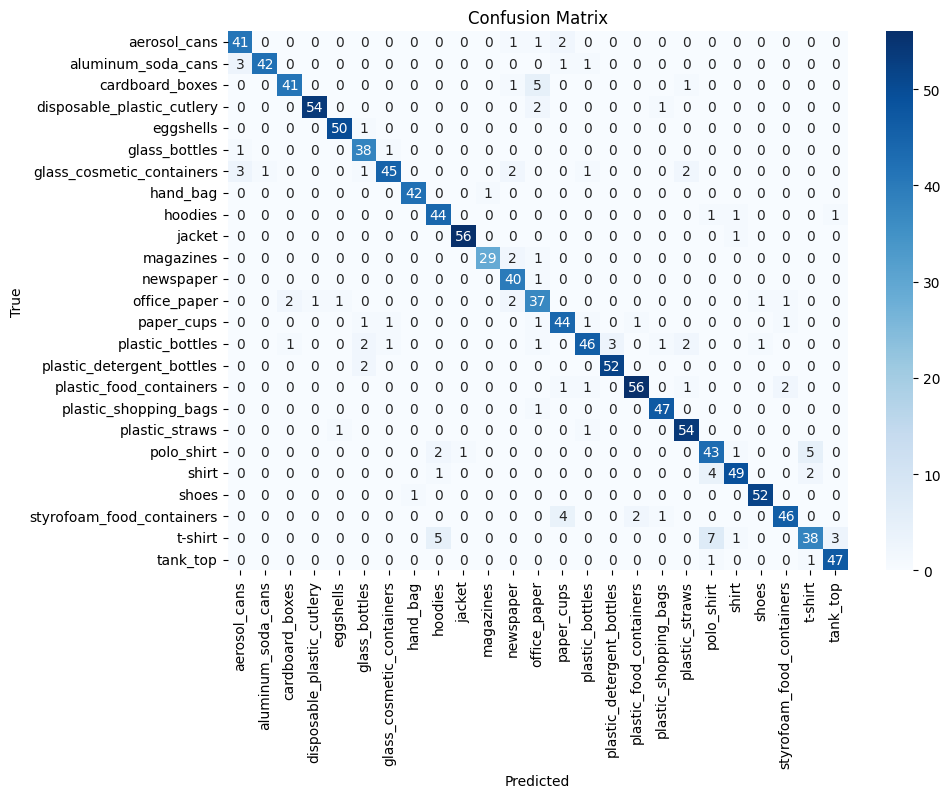

In [19]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, criterion, test_loader):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    corrects = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, dim=1)
            corrects += torch.sum(preds == labels.data)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    test_loss = running_loss / len(test_loader.dataset)
    test_accuracy = accuracy_score(all_labels, all_preds)

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    return all_labels, all_preds

def plot_confusion_matrix(labels, preds, classes):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the model
all_labels, all_preds = evaluate_model(model, criterion, test_loader)

# Plot the confusion matrix
plot_confusion_matrix(all_labels, all_preds, dataset.classes)


In [20]:
# Save the trained model and optimizer states
def save_model(model, optimizer, filepath='model.pth'):
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, filepath)
    print(f"Model saved to {filepath}")

# Specify the file path where you want to save the model
save_model(model, optimizer, filepath='trained_model.pth')


Model saved to trained_model.pth
